# Data wrangling

This notebook demonstrates the entire process of building a predictive model to suggest the first destination of new Airbnb Users. All the processes involved, such as data wrangling, exploratory data analysis, inferential statistics.

# Background

How to effectively enhance user experience and increase total bookings by utilizing huge dataset remains a question to answer. Airbnb opens this challenge to its potential employees. From their point of view, by accurately predicting the destination a new user might travel to for the first time,” Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand”.


# Problem Statement

As participants, we are required to predict the new users’ first booking destination at the granularity of country. There are 11 destinations to choose from, including Australia, Canada, Germany, Spain, France, Great Britain, Italy, Netherlands, Portugal, the U.S., and all the rest are labeled as “others”. Users who haven’t made a booking are categorized with the “NDF” label in the destination field.

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

The first step is to load all the data available to us in a Pandas Dataframe and extract basic information such as number of samples, number of null values rows, number of features, etc. The next step would be to deal with the missing values using a suitable method (dropping, interpolating, etc.) and convert certain features into a more suitable form for applying inferential statistics and machine learning algorithms.

### Age, Gender and Population Statistics

In [4]:
df_agb = pd.read_csv('data/age_gender_bkts.csv')
df_agb.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


In [5]:
#Check for all features by replacing the key of the mask.
df_agb[df_agb['year'].isnull()]

,age_bucket,country_destination,gender,population_in_thousands,year


This dataset has no null values amongst its features.

As a first step, let us deal with the age bucket. The ages are given in bins of size 5. We will convert this to a numerical value so that we can increase its versaility should the need arise (that is, it can be used both as a categorical and a continuous feature). As the bin size is reasonably small, we can define a new feature, mean_age which can represent ages without too much loss of information. The mean_age will be the average of the upper and lower range for that particular bin.

In [6]:
#Convert 100+ into a bin.
df_agb['age_bucket'] = df_agb['age_bucket'].apply(lambda x: '100-104' if x == '100+' else x)
#Define mean_age feature
df_agb['mean_age'] = df_agb['age_bucket'].apply(lambda x: (int(x.split('-')[0]) + int(x.split('-')[1]))/2)
df_agb = df_agb.drop('age_bucket', axis=1)
df_agb.head()

,country_destination,gender,population_in_thousands,year,mean_age
0,AU,male,1.0,2015.0,102.0
1,AU,male,9.0,2015.0,97.0
2,AU,male,47.0,2015.0,92.0
3,AU,male,118.0,2015.0,87.0
4,AU,male,199.0,2015.0,82.0


In [7]:
df_agb['country_destination'].value_counts()

AU    42
US    42
NL    42
GB    42
PT    42
FR    42
DE    42
IT    42
CA    42
ES    42
Name: country_destination, dtype: int64

In [8]:
df_agb['gender'].value_counts()

female    210
male      210
Name: gender, dtype: int64

The gender can also be turned into a categorical binary variable. Let us represent **male with 0 and female with 1.** Again, we do this just in case we require this variable to function as a numerical quantity. It must be stated that there is no immediate need for it and therefore, can be skipped.

In [9]:
df_agb['gender'] = df_agb['gender'].apply(lambda x: 0 if x == 'male' else 1)
df_agb['gender'].value_counts()

1    210
0    210
Name: gender, dtype: int64

In [10]:
df_agb['year'].value_counts()

2015.0    420
Name: year, dtype: int64

There is only value available for the year feature. Therefore, it makes no sense to keep this feature as it doesn't add any information about the data available to us. We shall drop this feature.

In [11]:
df_agb = df_agb.drop('year', axis=1)
df_agb.head()

,country_destination,gender,population_in_thousands,mean_age
0,AU,0,1.0,102.0
1,AU,0,9.0,97.0
2,AU,0,47.0,92.0
3,AU,0,118.0,87.0
4,AU,0,199.0,82.0


### Country Statistics

In [12]:
df_con = pd.read_csv('data/countries.csv')
df_con

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


### Sessions 

In [13]:
df_ses = pd.read_csv('data/sessions.csv')
df_ses.head(15)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.0
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.0
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0


In [14]:
df_ses.shape

(10567737, 6)

We will replace the unknown values with NaN to give it some semantic meaning. We can always revert back to unknown should the need arise or should our EDA suggest that labelling unavailable data as unknown values will lead to better predictions.

In [15]:
df_ses['action'] = df_ses['action'].replace('-unknown-', np.nan)
df_ses['action_type'] = df_ses['action_type'].replace('-unknown-', np.nan)
df_ses['action_detail'] = df_ses['action_detail'].replace('-unknown-', np.nan)

First, let us have a look at the secs_elapsed variable.

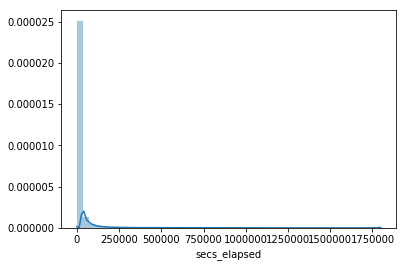

In [16]:
sns.distplot(df_ses[df_ses['secs_elapsed'].notnull()]['secs_elapsed'])

In [17]:
df_ses['secs_elapsed'].describe()

count    1.043171e+07
mean     1.940581e+04
std      8.888424e+04
min      0.000000e+00
25%      2.290000e+02
50%      1.147000e+03
75%      8.444000e+03
max      1.799977e+06
Name: secs_elapsed, dtype: float64

The average number of seconds per session is **19405 seconds** whereas the median value is **1147 seconds**. This suggests a heavily skewed dataset with some outlier observations influencing the mean of the distribution.

In [18]:
len(df_ses[df_ses['secs_elapsed'].isnull()])

136031

There are more than 136,000 fields for which we do not know the value. We need to either drop or interpolate these values. For the time being, let us fill the unavailable values with the median of the distribution. We use median since, as was mentioned earlier, this distribution is heavily influenced by outliers.

In [19]:
median_secs = df_ses['secs_elapsed'].median()
df_ses['secs_elapsed'] = df_ses['secs_elapsed'].fillna(median_secs)

In [20]:
df_ses['secs_elapsed'].describe()

count    1.056774e+07
mean     1.917078e+04
std      8.833430e+04
min      0.000000e+00
25%      2.370000e+02
50%      1.147000e+03
75%      8.193000e+03
max      1.799977e+06
Name: secs_elapsed, dtype: float64

As can be seen above, the interpolation has not significantly altered the summary statistics of the distribution. This is a good option for filling in the null values for the time being.

In [21]:
null_action = df_ses[(df_ses['action_type'].isnull()) | (df_ses['action_detail'].isnull()) | (df_ses['action'].isnull()) ]
null_action.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0


In [22]:
null_action.shape

(2237000, 6)

In [23]:
len(null_action['action'].drop_duplicates())

270

There are over 2.23 million fields that have incomplete information about the action, action type or action detail. This is approximately 20% of the data that we possess. Additionally, there are 270 types of action for which we have null values, so examining them one by one is simply not feasible manually.

Since this is not our training dataset, we will not drop the values. We shall keep because it is possible to extract information even from rows which have null columns.

In [24]:
df_ses[df_ses['device_type'].isnull()]

,user_id,action,action_type,action_detail,device_type,secs_elapsed


In [25]:
df_ses['device_type'] = df_ses['device_type'].replace('-unknown-', np.nan)

In [26]:
df_ses['device_type'].value_counts()

Mac Desktop                         3594286
Windows Desktop                     2658539
iPhone                              2105031
Android Phone                        839637
iPad Tablet                          683414
Android App Unknown Phone/Tablet     273652
Tablet                               139886
Linux Desktop                         28373
Chromebook                            22348
iPodtouch                              8198
Windows Phone                          2047
Blackberry                              979
Opera Phone                              68
Name: device_type, dtype: int64

As can be seen above, there are 13 types of devices that people are using. There is also certain activity for which we do not have data about the device. Let us check how many instances does that account for.

In [27]:
len(df_ses[df_ses['device_type'].isnull()])

211279

As with the action variables, we will not drop these values since this is not the dataset we will be applying our machine learning algorithms to. However, we will replace the unknown strings with NaN to give it more semantic meaning which might be useful in our analysis.

### Training Users

Let us now explore the training dataset which consists of our users for whom we need to predict the first destination. 

In [28]:
df_train = pd.read_csv('data/train_users_2.csv')
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [29]:
df_train.shape

(213451, 16)

In [30]:
df_train['gender'] = df_train['gender'].replace('-unknown-', np.nan)
df_train['first_browser'] = df_train['first_browser'].replace('-unknown-', np.nan)

In [31]:
df_train[df_train['first_device_type'].isnull()]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination


The following features in the dataset have no null values:

1. date_account_created
2. timestamp_first_active
3. signup_method
4. signup_flow
5. language
6. affiliate_channel
7. affiliate_provider
8. signup_app
9. first_device_type

The following features in the dataset have null values:

1. date_first_booking
2. gender
3. age
4. first_affiliate_tracked
5. first_browser

In [32]:
df_train[df_train['age'] > 120].head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
388,v2x0ms9c62,2010-04-11,20100411065602,2010-04-13,NaN,2014.0,basic,3,en,other,craigslist,untracked,Web,Windows Desktop,Firefox,FR
673,umf1wdk9uc,2010-05-25,20100525155541,NaN,FEMALE,2014.0,basic,2,en,other,craigslist,untracked,Web,Mac Desktop,Safari,NDF
1040,m82epwn7i8,2010-07-14,20100714230556,2010-07-15,MALE,2014.0,facebook,0,en,other,craigslist,untracked,Web,Mac Desktop,Chrome,US
1177,2th813zdx7,2010-07-25,20100725234419,2010-07-26,MALE,2013.0,facebook,3,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
1200,3amf04n3o3,2010-07-27,20100727190447,2010-07-29,FEMALE,2014.0,basic,2,en,direct,direct,untracked,Web,Windows Desktop,IE,US


We notice that there are samples for which the age is much greater than 120 (the oldest person is currently 114 years old). This is clearly polluted data and must be removed. Let us replace these values with NaN to denote that we do not know the real age of these people.

In [33]:
df_train['age'] = df_train['age'].apply(lambda x: np.nan if x > 120 else x)

## Inferential Statistics

### Gender Preference for Airbnb Bookings

In this section, we will be applying statistical tools to gain some inferences and insights into the kind of data we are dealing with and disovering relationships between various features of our dataset. 

To begin, let us check if there is a gender based preference for certain countries. In other words, does the gender of a person affect the first country s/he books an Airbnb in? To answer this question we will have to test the relationship between two categorical variables: Gender and Destination Country. Since the number of destination countries is multivariate, the **Chi Square Square Significance Test**.

Before we begin, we will make certain assumptions:
* We will consider only those users who have enlisted their gender as male or female. Unknown and other genders are not included in this analysis.
* We do not consider users who have never booked an Airbnb or have booked in a country not enlisted as a class (NDF and Other).

In [34]:
df_inf = df_train[(df_train['country_destination'] != 'NDF') & (df_train['country_destination'] != 'other') & (df_train['gender'] != 'OTHER') & (df_train['gender'].notnull())]
df_inf = df_inf[['id', 'gender', 'country_destination']]
df_inf.head()

,id,gender,country_destination
2,4ft3gnwmtx,FEMALE,US
6,lsw9q7uk0j,FEMALE,US
7,0d01nltbrs,FEMALE,US
8,a1vcnhxeij,FEMALE,US
10,yuuqmid2rp,FEMALE,US


In [35]:
df_inf['gender'].value_counts()

FEMALE    28833
MALE      24278
Name: gender, dtype: int64

In [36]:
df_inf['country_destination'].value_counts()

US    42151
FR     3297
IT     1790
GB     1563
ES     1530
CA      932
DE      774
NL      532
AU      395
PT      147
Name: country_destination, dtype: int64

#### Hypothesis Testing

For the hypothesis testing, we define the following:

* **Null Hypothesis:** There is no relationship between country preference and the sex of the customer.
* **Alternate Hypothesis:** There is a relationship between country preference and the sex of the customer.

We will assume our significance level, $\alpha$ to be 0.05.

In [37]:
observed = df_inf.pivot_table('id', ['gender'], 'country_destination', aggfunc='count').reset_index()
del observed.columns.name
observed = observed.set_index('gender')
observed

,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
gender,,,,,,,,,,
FEMALE,207,455,358,853,1962,881,1091,254,78,22694
MALE,188,477,416,677,1335,682,699,278,69,19457


In [38]:
chi2, p, dof, expected = stats.chi2_contingency(observed)

In [39]:
chi2

116.87183139602567

In [40]:
p

5.830126955071572e-21

The p-value that we have obtained is less than our chosen significance level. Therefore, we reject the null hypothesis and accept the negating alterate hypothesis. **There is a relationship between country preference and the sex of the customer.** This information can prove extremely useful to us when performing feature engineering in later steps.


### Signup Preferences

In this section, we will try to discover a relationship between the signup method and the signup device. A preliminary querying of our dataframe tells us that most users signup either through the standard basic method or through Facebook. Additionally, they login using either a desktop browser, a mobile browser or a mobile app.

Does the type of device (mobile or computer) affect the signup method to Airbnb? We will try to answer this question here. Again, as aboe, we will make certain assumptions.
* We will ignore the Google Signup Method as there are extremely few instances of it.
* We will consider iOs, Moweb and Android to all be of the Mobile Device Type.

In [41]:
df_signup = df_train[(df_train['signup_method'] != 'google')][['id', 'signup_method', 'signup_app']]
df_signup['device'] = df_signup['signup_app'].apply(lambda x: 'Computer' if x == 'Web' else 'Mobile')
df_signup.head()

,id,signup_method,signup_app,device
0,gxn3p5htnn,facebook,Web,Computer
1,820tgsjxq7,facebook,Web,Computer
2,4ft3gnwmtx,basic,Web,Computer
3,bjjt8pjhuk,facebook,Web,Computer
4,87mebub9p4,basic,Web,Computer


In [42]:
df_signup['signup_method'].value_counts()

basic       152897
facebook     60008
Name: signup_method, dtype: int64

In [43]:
df_signup['device'].value_counts()

Computer    182717
Mobile       30188
Name: device, dtype: int64

#### Hypothesis Testing

Let us now setup our hypothesis test. We will define the following:

* **Null Hypothesis:** There is no relationship between device type and signup method.
* **Alternate Hypothesis:** There is a relationship between device type and signup method.

Assume the significance level $\alpha$ to be at 0.05.

We will be performing the same hypothesis test using two different statistical tools: The Chi Square Significance Test and the Z-Statistic Test. If performed correctly, both tests should give us the same results.

In [44]:
df_signup = df_signup.pivot_table('id', ['device'], 'signup_method', aggfunc='count')
df_signup.index = ['Computer', 'Mobile']
df_signup.columns = ['Basic', 'Facebook']
df_signup

,Basic,Facebook
Computer,131237,51480
Mobile,21660,8528


#### Chi Square Test

In [45]:
chi2, p, dof, expected = stats.chi2_contingency(df_signup, correction=False)

In [46]:
chi2

0.07183824273421707

In [47]:
p

0.7886788661023779

The p-value obtained is higher than our chosen significance level. Therefore, we are not in a position to reject the null hypothesis. It stands. **There is no relationship between device type and signup method.** Let us perform the same hypothesis test using the Z-Test and compare the results and the p-value obtained.

#### Two Sample Significance Test

Let us now do the same hypothesis testing using the two sample significance test for proportions.

In [48]:
df_signup.loc['Total'] = [ df_signup['Basic'].sum(), df_signup['Facebook'].sum()]
df_signup['Total'] = df_signup['Basic'] + df_signup['Facebook']
df_signup

,Basic,Facebook,Total
Computer,131237,51480,182717
Mobile,21660,8528,30188
Total,152897,60008,212905


In [49]:
fb_prop = df_signup.loc['Mobile', 'Facebook']/df_signup.loc['Total', 'Facebook']
fb_std = df_signup.loc['Mobile', 'Facebook'] * ((1 - fb_prop) ** 2) + df_signup.loc['Computer', 'Facebook'] * ((0 - fb_prop) ** 2)
fb_std = np.sqrt(fb_std/df_signup.loc['Total', 'Facebook'])

fb_prop, fb_std

(0.14211438474870017, 0.3491674188640724)

In [50]:
basic_prop = df_signup.loc['Mobile', 'Basic']/df_signup.loc['Total', 'Basic']
basic_std = df_signup.loc['Mobile', 'Basic'] * ((1 - basic_prop) ** 2) + df_signup.loc['Computer', 'Basic'] * ((0 - basic_prop) ** 2)
basic_std = np.sqrt(basic_std/df_signup.loc['Total', 'Basic'])

basic_prop, basic_std

(0.14166399602346677, 0.34870518816635054)

In [51]:
h0_prop = 0

prop_diff = fb_prop - basic_prop
p_hat = (df_signup.loc['Mobile', 'Basic'] + df_signup.loc['Mobile', 'Facebook'])/(df_signup.loc['Total', 'Basic'] + df_signup.loc['Total', 'Facebook']) 
var_diff = p_hat * (1- p_hat) * (1/df_signup.loc['Total', 'Basic'] + 1/df_signup.loc['Total', 'Facebook'])
sigma_diff = np.sqrt(var_diff)

prop_diff, sigma_diff

(0.0004503887252333971, 0.001680388342245922)

In [52]:
z = (prop_diff - h0_prop) / sigma_diff
z

0.2680265709481359

In [53]:
p = (1-stats.norm.cdf(z))*2
p

0.7886788661023794

The p-value obtained is higher than our chosen significance level. Therefore, we are not in a position to reject the null hypothesis. It stands. **There is no relationship between device type and signup method.**

Also notice that the p-values obtained for Two Sample Significance Test and Chi Square Significance Test (without Correction) is **exactly the same.** We are now in a position to summarise and present our results based on the statistical analysis performed.

### Conclusions

* There is **a relationship** between gender and Airbnb Country Destination. In other words, the gender influences your country of choice.
* There is **no relationship** between device type and signup method. The two variables are independent of each other.
* The results obtained from Chi Square Significance Test and Two Sample Significance Test are **exactly the same**.

References

Repositories

https://github.com/karvenka/kaggle-airbnb/blob/master/notebooks/Venkatesan_Karthick_Final_Project_Report.ipynb

https://github.com/Sapphirine/Airbnb-New-User-Bookings-Prediction/blob/master/preprocessing%26prediction.ipynb

https://github.com/Currie32/AirBnB-Predicting-Destination/blob/master/Predicting_Destination.ipynb

Kaggle Competition

https://www.kaggle.com/meicher/predicting-first-destination-4-models

https://www.kaggle.com/svpons/three-level-classification-architecture

The code in the document by Kandarp Vyas is licensed under the MIT License https://opensource.org/licenses/MIT